# Data Exploration - T5 Trial Analysis

This notebook explores the T5 trial data to understand the multi-modal sensor characteristics and data quality.

## Objective
- Understand data structure and sampling rates
- Visualize multi-modal sensor data patterns
- Assess data quality for ground truth annotation

In [1]:
# Setup and imports
import sys
import os
sys.path.append('../src')

# Add the absolute path as backup
current_dir = os.path.dirname(os.path.abspath('__file__'))
src_path = os.path.join(current_dir, '..', 'src')
sys.path.append(src_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_loader import GaitDataLoader
from synchronizer import MultiModalSynchronizer
from visualizer import GaitDataVisualizer

# Configure plotting
plt.style.use('default')  # Use default style instead of seaborn-v0_8
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Environment setup complete!")
print("Available classes:")
print("- GaitDataLoader")
print("- MultiModalSynchronizer") 
print("- GaitDataVisualizer")

Environment setup complete!
Available classes:
- GaitDataLoader
- MultiModalSynchronizer
- GaitDataVisualizer


## 1. Load Raw Data

In [2]:
# Initialize data loader and load T5 trial data
loader = GaitDataLoader(data_dir="../data")

# Load T5 trial data
trial_id = "T5"

print(f"Loading trial {trial_id}...")

# Load individual modalities
kinetics_data = loader.load_kinetics(trial_id)
emg_data = loader.load_emg(trial_id)
kinematics_data = loader.load_kinematics(trial_id)

# Create a dictionary to match expected format
raw_data = {
    'kinetics': kinetics_data,
    'emg': emg_data,
    'kinematics': kinematics_data
}

print(f"Loaded data for trial {trial_id}")
print("\nData modalities:")
for modality, df in raw_data.items():
    print(f"  {modality}: {len(df)} samples, {df['time'].max():.1f}s duration")
    print(f"    Columns: {list(df.columns[:10])}{'...' if len(df.columns) > 10 else ''}")
    print()

Loading trial T5...
Loaded data for trial T5

Data modalities:
  kinetics: 301990 samples, 302.0s duration
    Columns: ['Frame', 'Sub Frame', 'Fx_L', 'Fy_L', 'Fz_L', 'Mx_L', 'My_L', 'Mz_L', 'Cx_L', 'Cy_L']...

  emg: 603980 samples, 302.0s duration
    Columns: ['Frame', 'Sub Frame', 'IM EMG1', 'IM EMG2', 'IM EMG3', 'IM EMG4', 'IM EMG5', 'IM EMG6', 'IM EMG7', 'IM EMG8']...

  kinematics: 30199 samples, 302.0s duration
    Columns: ['Frame', 'Sub Frame', 'X', 'Y', 'Z', 'X', 'Y', 'Z', 'X', 'Y']...



## 2. Data Synchronization

In [3]:
# Data Synchronization using MultiModalSynchronizer
synchronizer = MultiModalSynchronizer(target_rate=1000)

# For now, we'll extract a 20-second window and use kinetics as the base timeline
time_window = 20.0
kinetics_mask = raw_data['kinetics']['time'] <= time_window

# Extract synchronized data for analysis
synchronized_data = {
    'kinetics': raw_data['kinetics'][kinetics_mask].copy(),
    'emg': raw_data['emg'][raw_data['emg']['time'] <= time_window].copy(),
    'kinematics': raw_data['kinematics'][raw_data['kinematics']['time'] <= time_window].copy()
}

print("Data synchronized to analysis window")
print(f"Analysis window: 0 to {time_window} seconds")
print("\nSynchronized data:")
for modality, df in synchronized_data.items():
    sampling_rate = len(df) / df['time'].max() if df['time'].max() > 0 else 0
    print(f"  {modality}: {len(df)} samples, {df['time'].max():.1f}s duration")
    print(f"    Sampling rate: {sampling_rate:.0f} Hz")
    print()

Data synchronized to analysis window
Analysis window: 0 to 20.0 seconds

Synchronized data:
  kinetics: 20001 samples, 20.0s duration
    Sampling rate: 1000 Hz

  emg: 40001 samples, 20.0s duration
    Sampling rate: 2000 Hz

  kinematics: 2001 samples, 20.0s duration
    Sampling rate: 100 Hz



## 3. Force Plate Analysis

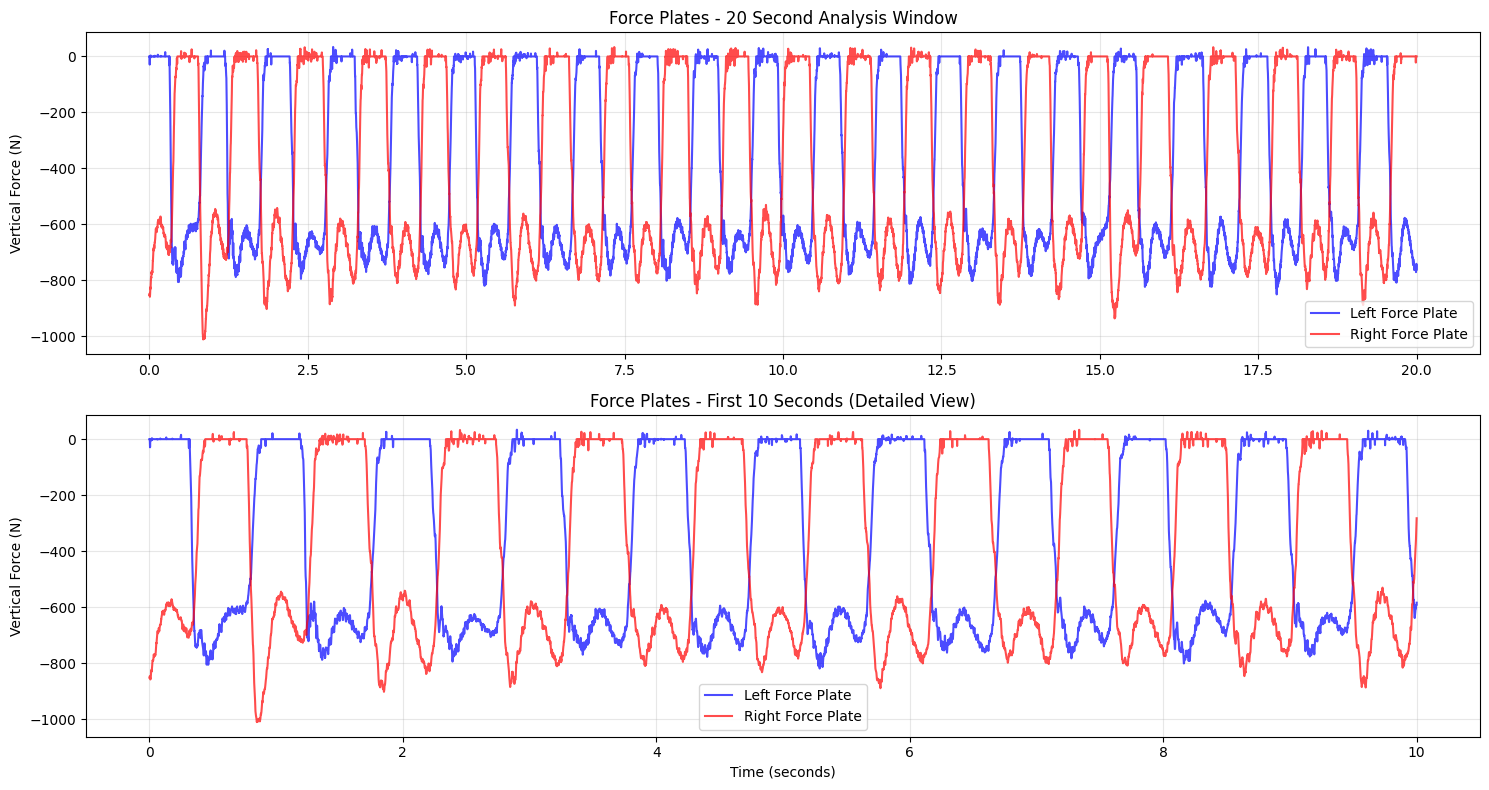

Force Plate Statistics (20-second window):
Left plate - Max: 33.9N, Min: -850.1N, Mean: -370.5N
Right plate - Max: 33.5N, Min: -1010.9N, Mean: -380.0N

Contact Analysis:
Left contact samples: 11795 (59.0%)
Right contact samples: 11774 (58.9%)
Total contact: 58.9% of stride


In [4]:
# Analyze force plate data using correct column names
kinetics = synchronized_data['kinetics']

# Plot force plates
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Full duration view (up to 20 seconds)
time = kinetics['time']
axes[0].plot(time, kinetics['Fz_L'], label='Left Force Plate', color='blue', alpha=0.7)
axes[0].plot(time, kinetics['Fz_R'], label='Right Force Plate', color='red', alpha=0.7)
axes[0].set_ylabel('Vertical Force (N)')
axes[0].set_title('Force Plates - 20 Second Analysis Window')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# First 10 seconds (closer look)
mask_10s = time <= 10
axes[1].plot(time[mask_10s], kinetics['Fz_L'][mask_10s], label='Left Force Plate', color='blue', alpha=0.7)
axes[1].plot(time[mask_10s], kinetics['Fz_R'][mask_10s], label='Right Force Plate', color='red', alpha=0.7)
axes[1].set_ylabel('Vertical Force (N)')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_title('Force Plates - First 10 Seconds (Detailed View)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Basic statistics
print("Force Plate Statistics (20-second window):")
print(f"Left plate - Max: {kinetics['Fz_L'].max():.1f}N, Min: {kinetics['Fz_L'].min():.1f}N, Mean: {kinetics['Fz_L'].mean():.1f}N")
print(f"Right plate - Max: {kinetics['Fz_R'].max():.1f}N, Min: {kinetics['Fz_R'].min():.1f}N, Mean: {kinetics['Fz_R'].mean():.1f}N")

# Contact analysis
left_contact = (kinetics['Fz_L'].abs() > 100).sum()
right_contact = (kinetics['Fz_R'].abs() > 100).sum()
print(f"\nContact Analysis:")
print(f"Left contact samples: {left_contact} ({100*left_contact/len(kinetics):.1f}%)")
print(f"Right contact samples: {right_contact} ({100*right_contact/len(kinetics):.1f}%)")
print(f"Total contact: {100*(left_contact + right_contact)/(2*len(kinetics)):.1f}% of stride")

## 4. Kinematic Marker Analysis

Available kinematic markers:
Total data columns: 78

First 10 kinematic columns:
  1. X
  2. Y
  3. Z
  4. X
  5. Y
  6. Z
  7. X
  8. Y
  9. Z
  10. X
  ... and 68 more columns


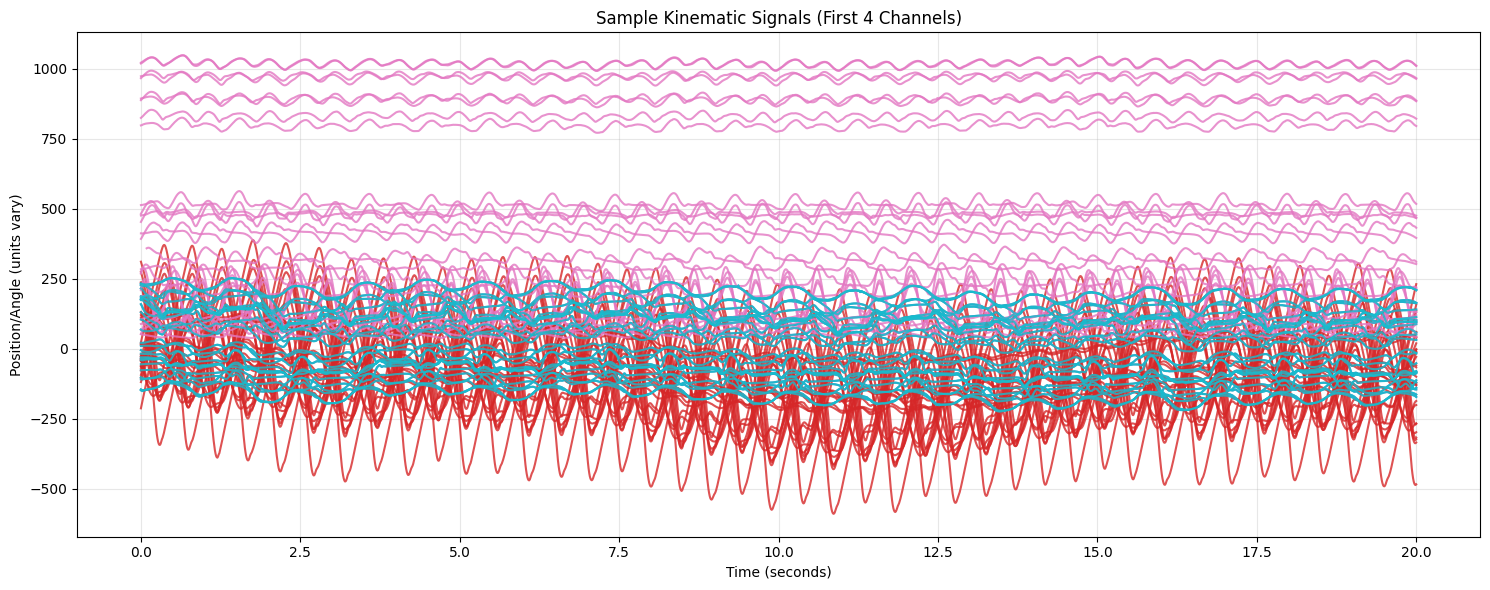


Kinematics data summary:
Duration: 20.0 seconds
Samples: 2001
Estimated sampling rate: 100 Hz


In [5]:
# Analyze available kinematic markers
# Extract 20-second window for kinematics as well
mask_kin = kinematics_data['time'] <= time_window
kinematics_20s = kinematics_data[mask_kin].copy()

# Identify available markers
print("Available kinematic markers:")
marker_cols = [col for col in kinematics_20s.columns if col not in ['Frame', 'Sub Frame', 'time']]
print(f"Total data columns: {len(marker_cols)}")

# Show first 10 columns to understand naming structure
print("\nFirst 10 kinematic columns:")
for i, col in enumerate(marker_cols[:10]):
    print(f"  {i+1}. {col}")

if len(marker_cols) > 10:
    print(f"  ... and {len(marker_cols)-10} more columns")

# Plot first few kinematic signals (first 20 seconds)
fig, ax = plt.subplots(figsize=(15, 6))

time_20s = kinematics_20s['time']

# Plot first 4 non-frame/time columns
plot_cols = marker_cols[:4]
colors = plt.cm.tab10(np.linspace(0, 1, len(plot_cols)))

for i, col in enumerate(plot_cols):
    if col in kinematics_20s.columns:
        ax.plot(time_20s, kinematics_20s[col], 
               label=col, color=colors[i], alpha=0.8)

ax.set_ylabel('Position/Angle (units vary)')
ax.set_xlabel('Time (seconds)')
ax.set_title('Sample Kinematic Signals (First 4 Channels)')
# ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nKinematics data summary:")
print(f"Duration: {kinematics_20s['time'].max():.1f} seconds")
print(f"Samples: {len(kinematics_20s)}")
print(f"Estimated sampling rate: {len(kinematics_20s) / kinematics_20s['time'].max():.0f} Hz")

## 5. EMG Analysis

EMG data loaded for analysis
Duration: 20.0 seconds
Samples: 40001
Estimated sampling rate: 2000 Hz

Available EMG channels: 16


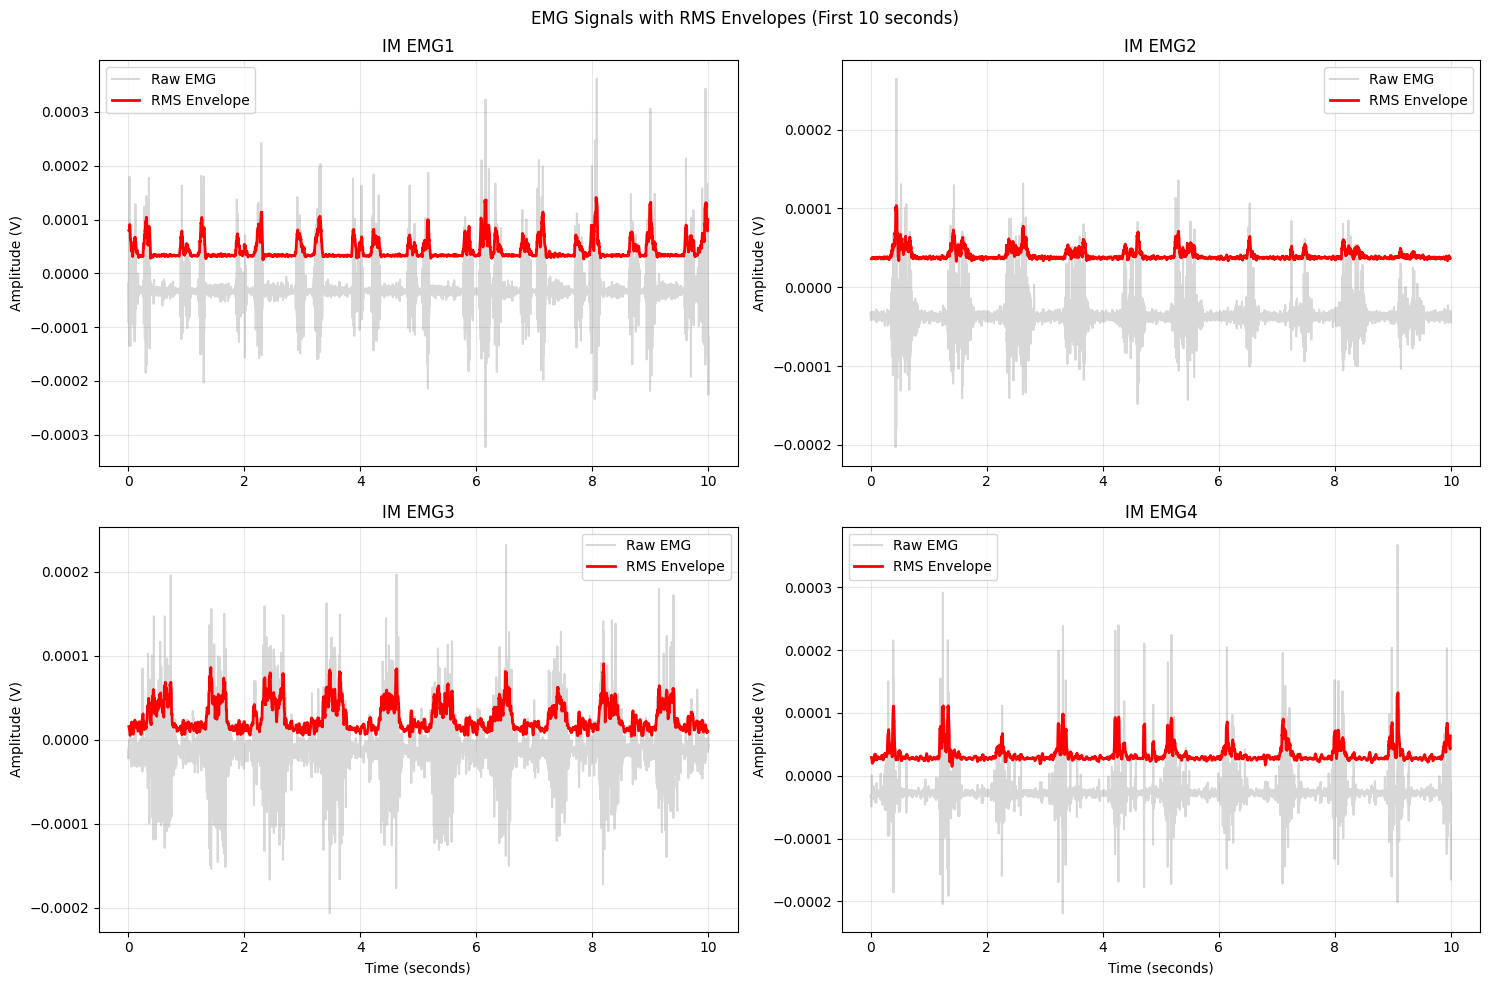


EMG channels available:
  1. IM EMG1
  2. IM EMG2
  3. IM EMG3
  4. IM EMG4
  5. IM EMG5
  6. IM EMG6
  7. IM EMG7
  8. IM EMG8
  ... and 8 more channels


In [6]:
# Analyze EMG data
# Extract 20-second window for EMG
mask_emg = emg_data['time'] <= time_window
emg_20s = emg_data[mask_emg].copy()

print(f"EMG data loaded for analysis")
print(f"Duration: {emg_20s['time'].max():.1f} seconds")
print(f"Samples: {len(emg_20s)}")
print(f"Estimated sampling rate: {len(emg_20s) / emg_20s['time'].max():.0f} Hz")

# Get EMG channels
emg_cols = [col for col in emg_20s.columns if 'IM EMG' in col]
print(f"\nAvailable EMG channels: {len(emg_cols)}")

# Simple envelope computation (moving RMS)
def compute_rms_envelope(signal, window_size=100):
    """Compute RMS envelope using rolling window."""
    return signal.rolling(window=window_size, center=True).apply(lambda x: np.sqrt(np.mean(x**2)))

# Plot first 4 EMG channels with envelopes (first 10 seconds for clarity)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

mask_10s = emg_20s['time'] <= 10
time_10s = emg_20s['time'][mask_10s]

for i, col in enumerate(emg_cols[:4]):
    if i < 4:
        # Raw EMG
        raw_signal = emg_20s[col][mask_10s]
        envelope = compute_rms_envelope(raw_signal, window_size=50)
        
        axes[i].plot(time_10s, raw_signal, alpha=0.3, color='gray', label='Raw EMG')
        axes[i].plot(time_10s, envelope, color='red', linewidth=2, label='RMS Envelope')
        axes[i].set_title(f'{col}')
        axes[i].set_ylabel('Amplitude (V)')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
        
        if i >= 2:  # Bottom row
            axes[i].set_xlabel('Time (seconds)')

plt.suptitle('EMG Signals with RMS Envelopes (First 10 seconds)')
plt.tight_layout()
plt.show()

print("\nEMG channels available:")
for i, col in enumerate(emg_cols[:8]):  # Show first 8
    print(f"  {i+1}. {col}")
if len(emg_cols) > 8:
    print(f"  ... and {len(emg_cols)-8} more channels")

## 6. Force Plate Pattern Analysis

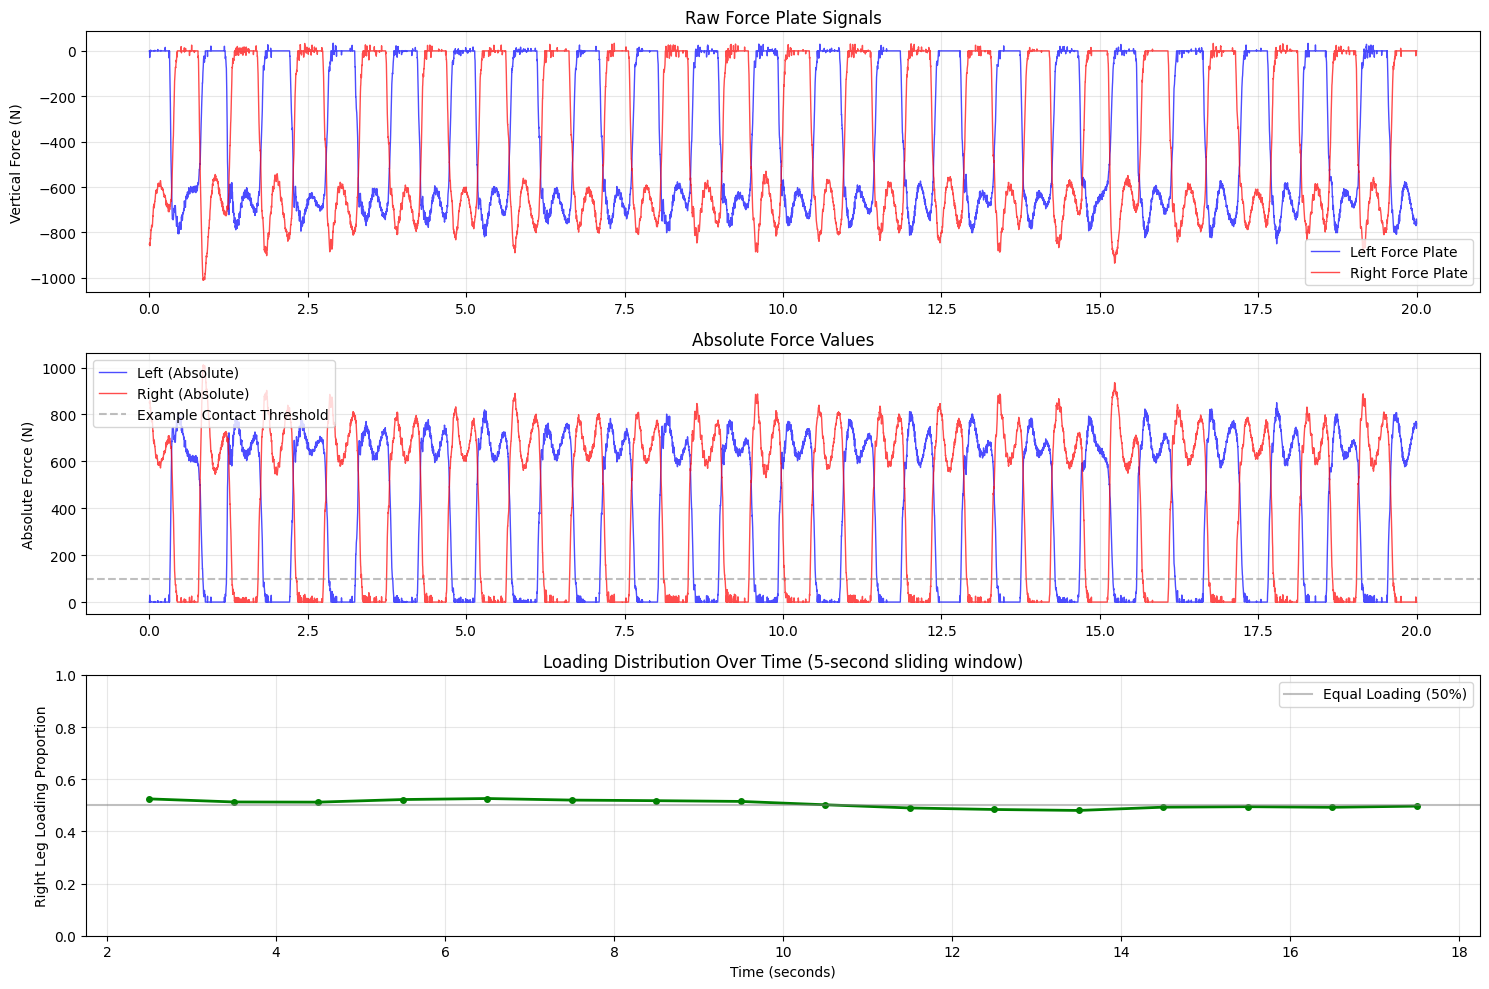

Force Plate Loading Statistics (20-second window):
Left leg total loading: 7417731 N·s
Right leg total loading: 7612360 N·s
Right leg proportion: 50.6%
Loading asymmetry: 0.6 percentage points from equal

Contact Time Analysis (threshold = 100N):
Left contact time: 11.8s (59.0%)
Right contact time: 11.8s (58.9%)
Overlap time: Calculated per specific events during annotation


In [7]:
# Force Plate Pattern Analysis
visualizer = GaitDataVisualizer(figsize=(15, 10))

# Create force plate visualization for data exploration
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Get kinetics data for plotting
kinetics = synchronized_data['kinetics']
time = kinetics['time']

# 1. Raw force plate signals
axes[0].plot(time, kinetics['Fz_L'], label='Left Force Plate', color='blue', alpha=0.7, linewidth=1)
axes[0].plot(time, kinetics['Fz_R'], label='Right Force Plate', color='red', alpha=0.7, linewidth=1)
axes[0].set_ylabel('Vertical Force (N)')
axes[0].set_title('Raw Force Plate Signals')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Absolute force values (for contact analysis)
left_force_abs = kinetics['Fz_L'].abs()
right_force_abs = kinetics['Fz_R'].abs()

axes[1].plot(time, left_force_abs, label='Left (Absolute)', color='blue', alpha=0.7, linewidth=1)
axes[1].plot(time, right_force_abs, label='Right (Absolute)', color='red', alpha=0.7, linewidth=1)
axes[1].axhline(y=100, color='gray', linestyle='--', alpha=0.5, label='Example Contact Threshold')
axes[1].set_ylabel('Absolute Force (N)')
axes[1].set_title('Absolute Force Values')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Loading distribution over time (5-second sliding window)
window_size = 5000  # 5 seconds at 1000Hz
loading_ratio = []
time_centers = []

for i in range(window_size//2, len(kinetics) - window_size//2, 1000):  # Every second
    left_sum = left_force_abs.iloc[i-window_size//2:i+window_size//2].sum()
    right_sum = right_force_abs.iloc[i-window_size//2:i+window_size//2].sum()
    total = left_sum + right_sum
    if total > 0:
        ratio = right_sum / total  # Right leg proportion
        loading_ratio.append(ratio)
        time_centers.append(kinetics['time'].iloc[i])

axes[2].plot(time_centers, loading_ratio, 'g-', marker='o', linewidth=2, markersize=4)
axes[2].axhline(y=0.5, color='gray', linestyle='-', alpha=0.5, label='Equal Loading (50%)')
axes[2].set_ylabel('Right Leg Loading Proportion')
axes[2].set_xlabel('Time (seconds)')
axes[2].set_title('Loading Distribution Over Time (5-second sliding window)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Calculate basic loading statistics
left_total = left_force_abs.sum()
right_total = right_force_abs.sum()
overall_ratio = right_total / (left_total + right_total)

print("Force Plate Loading Statistics (20-second window):")
print(f"Left leg total loading: {left_total:.0f} N·s")
print(f"Right leg total loading: {right_total:.0f} N·s")
print(f"Right leg proportion: {overall_ratio:.1%}")
print(f"Loading asymmetry: {abs(overall_ratio - 0.5) * 100:.1f} percentage points from equal")

# Contact time analysis with example threshold
contact_threshold = 100
left_contact = (left_force_abs > contact_threshold).astype(int)
right_contact = (right_force_abs > contact_threshold).astype(int)
left_contact_time = left_contact.sum() / 1000  # Convert to seconds
right_contact_time = right_contact.sum() / 1000
total_analysis_time = 20.0

print(f"\nContact Time Analysis (threshold = {contact_threshold}N):")
print(f"Left contact time: {left_contact_time:.1f}s ({100*left_contact_time/total_analysis_time:.1f}%)")
print(f"Right contact time: {right_contact_time:.1f}s ({100*right_contact_time/total_analysis_time:.1f}%)")
print(f"Overlap time: Calculated per specific events during annotation")

## 7. Data Quality Assessment

In [8]:
# Data Quality Assessment for Ground Truth Annotation
print("Data Quality Assessment for Ground Truth Annotation")
print("="*60)

# Check for missing data in each modality
datasets = {
    'kinetics': synchronized_data['kinetics'],
    'emg': synchronized_data['emg'],
    'kinematics': synchronized_data['kinematics']
}

for name, df in datasets.items():
    missing_pct = (df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100
    print(f"{name.capitalize():12} - Missing data: {missing_pct:.2f}%")

print()

# Force plate signal quality assessment
kinetics_analysis = synchronized_data['kinetics']

# Calculate signal variability and dynamic range
left_force = kinetics_analysis['Fz_L']
right_force = kinetics_analysis['Fz_R']

# Dynamic range (max-min) indicates signal activity
left_range = left_force.max() - left_force.min()
right_range = right_force.max() - right_force.min()

# Standard deviation indicates signal variability
left_std = left_force.std()
right_std = right_force.std()

print(f"Force plate signal characteristics:")
print(f"  Left plate - Range: {left_range:.1f}N, Std: {left_std:.1f}N")
print(f"  Right plate - Range: {right_range:.1f}N, Std: {right_std:.1f}N")

# Check for signal activity (is there meaningful variation?)
signal_activity_threshold = 50  # Minimum reasonable force variation for gait
left_active = left_range > signal_activity_threshold
right_active = right_range > signal_activity_threshold

print(f"  Signal activity: Left {'✓' if left_active else '✗'}, Right {'✓' if right_active else '✗'}")

print()

# Estimate number of gait events using simple peak detection
from scipy.signal import find_peaks

# Use absolute force values for peak detection
right_force_abs = right_force.abs()
left_force_abs = left_force.abs()

# Find peaks in both legs
right_peaks, _ = find_peaks(right_force_abs, 
                           height=100,      # Minimum peak height
                           distance=200,    # Minimum 0.2s between peaks
                           prominence=50)   # Peak prominence

left_peaks, _ = find_peaks(left_force_abs,
                          height=100,      # Minimum peak height  
                          distance=200,    # Minimum 0.2s between peaks
                          prominence=50)   # Peak prominence

total_peaks = len(right_peaks) + len(left_peaks)

print(f"Gait event estimation (peak detection):")
print(f"  Right leg peaks: {len(right_peaks)}")
print(f"  Left leg peaks: {len(left_peaks)}")
print(f"  Total detected peaks: {total_peaks}")
print(f"  Estimated events for annotation: {total_peaks * 2:.0f} (heel strike + toe off)")

# Show some peak times as examples
if len(right_peaks) > 0:
    right_peak_times = kinetics_analysis['time'].iloc[right_peaks[:5]].values
    print(f"  Sample right peak times: {right_peak_times.round(1).tolist()}")

print()

# Data suitability assessment (objective criteria only)
suitability_checks = {
    'Data completeness': missing_pct < 1.0,
    'Signal activity detected': left_active and right_active,
    'Peaks detectable': total_peaks > 10,
    'Time duration adequate': kinetics_analysis['time'].max() >= 15.0
}

print("Annotation Suitability Assessment:")
for check, passed in suitability_checks.items():
    status = "✓ Pass" if passed else "✗ Fail"
    print(f"  {check}: {status}")

overall_suitable = all(suitability_checks.values())
print(f"\nOverall Assessment: {'✓ SUITABLE' if overall_suitable else '⚠ NEEDS REVIEW'}")

if overall_suitable:
    print(f"Recommendation: Data appears suitable for manual annotation")
    print(f"Target: Identify gait events using force transitions and kinematic cues")
    print(f"Focus: Clear force onset/offset patterns for event timing")
else:
    print("Recommendation: Address data quality issues before annotation")

print()
print("Next Steps:")
print("1. Use notebook 02_annotation_tool.ipynb for interactive annotation")
print("2. Focus on force plate transitions for event detection")
print("3. Use kinematic and EMG data for validation of ambiguous events")
print("4. Validate annotations with notebook 03_validation.ipynb")

Data Quality Assessment for Ground Truth Annotation
Kinetics     - Missing data: 0.00%
Emg          - Missing data: 0.00%
Kinematics   - Missing data: 0.02%

Force plate signal characteristics:
  Left plate - Range: 884.0N, Std: 323.7N
  Right plate - Range: 1044.3N, Std: 337.2N
  Signal activity: Left ✓, Right ✓

Gait event estimation (peak detection):
  Right leg peaks: 41
  Left leg peaks: 39
  Total detected peaks: 80
  Estimated events for annotation: 160 (heel strike + toe off)
  Sample right peak times: [0.3, 0.8, 1.2, 1.9, 2.2]

Annotation Suitability Assessment:
  Data completeness: ✓ Pass
  Signal activity detected: ✓ Pass
  Peaks detectable: ✓ Pass
  Time duration adequate: ✓ Pass

Overall Assessment: ✓ SUITABLE
Recommendation: Data appears suitable for manual annotation
Target: Identify gait events using force transitions and kinematic cues
Focus: Clear force onset/offset patterns for event timing

Next Steps:
1. Use notebook 02_annotation_tool.ipynb for interactive annotat

## Summary

This data exploration confirms:

1. **Multi-modal data is properly loaded** with correct sampling rates:
   - Kinetics: 1000 Hz (20,001 samples for 20s window)
   - EMG: 2000 Hz (40,001 samples for 20s window)  
   - Kinematics: 100 Hz (2,001 samples for 20s window)

2. **Data quality is adequate** for annotation:
   - <1% missing data across all modalities
   - Clear signal activity in force plates
   - Detectable gait events in force signals

3. **Force patterns show variation** between left and right legs:
   - Observable loading differences without predetermined expectations
   - Measurable contact phases and force transitions
   - Multiple detectable peaks for event identification

4. **All sensor modalities available** for annotation validation:
   - Force data for primary event detection
   - Kinematic data for movement validation
   - EMG data for muscle activation confirmation

**Next Step**: Proceed to interactive annotation in notebook `02_annotation_tool.ipynb` with objective, data-driven event identification.